In [1]:
# Standard library imports
import os
import time

# Third-party imports
import imageio
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp
import torch
import torch.nn as nn
from IPython import display
from IPython.display import clear_output
from scipy.io import loadmat
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# Local application/library specific imports
from kan import *
import use_KAN
# from use_KAN import *

from use_training_set import *
import yaml

parameters mean: [ 0.24268419  0.25925395 13.01958803]
parameters std: [0.11136719 0.13834257 6.95043716]
parameters shape: (8486, 3)
SQ shape: (8486, 95)
Q shape: (95,)
Outliers are at indices: (array([2409]), array([0]))


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# cpu = torch.device('cpu')
# device = cpu
torch.set_default_dtype(torch.float32)

cuda


## load training sets

In [3]:
config_file = 'setup_ts_full.txt'
x_train, y_train, Q_train = load_training_data(config_file)
parameters_list, SQ_list = load_grid_data(config_file)
x_train_torch = use_KAN.to_torch_device(x_train, device=device)
y_train_torch = use_KAN.to_torch_device(y_train, device=device)

# indexing
def id_params(parameters):
    tol = 1e-6
    id_eta = np.abs(parameters_list[:,0]-parameters[0])<tol
    id_kappa = np.abs(parameters_list[:,1]-parameters[1])<tol
    id_A = np.abs(parameters_list[:,2]-parameters[2])<tol
    return np.where(id_eta*id_kappa*id_A)[0]

parameters mean: [ 0.24268419  0.25925395 13.01958803]
parameters std: [0.11136719 0.13834257 6.95043716]
parameters shape: (8486, 3)
SQ shape: (8486, 95)
Q shape: (95,)


Outliers are at indices: (array([2409]), array([0]))


In [4]:
print(np.unique(parameters_list[:,0]))
print(np.unique(parameters_list[:,1]))
print(np.unique(parameters_list[:,2]))

[0.015 0.03  0.045 0.06  0.075 0.09  0.105 0.12  0.135 0.15  0.165 0.18
 0.195 0.21  0.225 0.24  0.255 0.27  0.285 0.3   0.315 0.33  0.345 0.36
 0.375 0.39  0.405 0.42  0.435 0.45 ]
[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5 ]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25.]


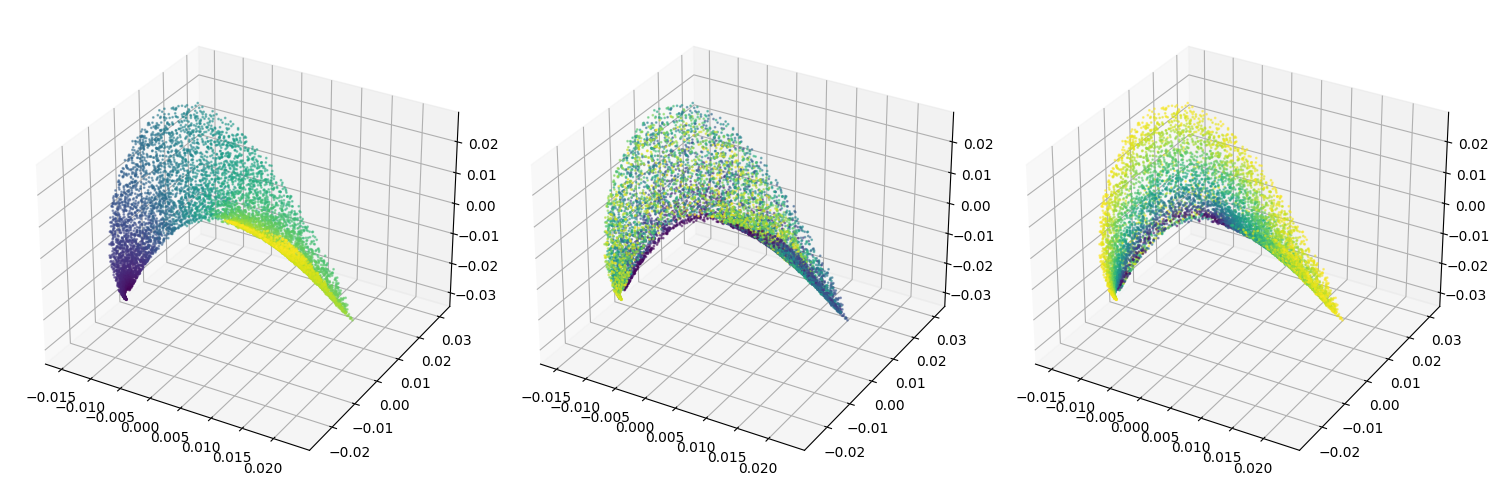

In [5]:
# Perform SVD
y_train_ave = np.mean(y_train, axis=0)
y_train_centered = y_train - y_train_ave
U, S, Vt = np.linalg.svd(y_train_centered, full_matrices=False)

# Get the first 3 principal components
PC = U[:, :3]

# Create a 3D plot
fig = plt.figure(figsize=(15, 5))
colormap = plt.cm.get_cmap('viridis')  # or any other colormap you like

for i in range(3):
    # Create a colormap based on x_train
    colors = colormap((x_train[:,i]-np.min(x_train[:,i]))/(np.max(x_train[:,i])-np.min(x_train[:,i])))

    ax = fig.add_subplot(1,3,i+1, projection='3d')
    ax.scatter(PC[:, 0], PC[:, 1], PC[:, 2], c=colors, s=1, alpha=0.5)

plt.tight_layout()
plt.show()

## load pretrained KAN model

In [6]:
def calculate_output_size(input_size, filter_size, padding, stride):
    return int((input_size - filter_size + 2*padding) / stride + 1)

def to_torch(array):
    return torch.from_numpy(array).float()

cuda0 = torch.device('cuda:0')
cpu = torch.device('cpu')
def to_torch_device(array,device=device):
    return torch.from_numpy(array.astype('float32')).float().to(device)


In [7]:
with open('setup_model_9_7.txt', 'r') as file:
    config = yaml.safe_load(file)
  
use_KAN.update_device(device)  
model_KAN = use_KAN.build_model(config['Model Setup'], device=device)

Device set to: cuda
All relevant tensors and models have been moved to the new device.
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


In [8]:
model_KAN.load_state_dict(torch.load('./saved_model/KAN/model_9_7_sin_full_ft.pth'))

<All keys matched successfully>

In [9]:
def f_SQ_KAN(model, x, Q=Q):
    # Extract phi from x
    phi = x[:, 0]*1
    
    # Transform x using kan_aug
    n_data = x.shape[0]
    x = x.view(-1, 3)
    x_transformed = model.kan_aug(x)
    
    # Transform Q using to_torch_device
    Q_torch = to_torch_device(Q)
    Q_torch_scale = to_torch_device((Q - 6) / 20)
    
    # Expand dimensions to match Q_torch
    x_expanded = x_transformed.unsqueeze(1).expand(-1, Q_torch_scale.size(0), -1)
    Q_expanded = Q_torch_scale.unsqueeze(0).unsqueeze(-1).expand(x.size(0), -1, x.size(-1))
    
    # Combine Q and x
    Q_params = torch.cat([Q_expanded, x_expanded], dim=-1)
    Q_params_reshaped = Q_params.view(-1, Q_params.size(-1))
    
    # Produce G(Q, x) using kan
    G_full = model.kan(Q_params_reshaped)
    G_full_reshaped = G_full.view(x_transformed.size(0), Q_torch_scale.size(0), 3)  # (n_data, n_Q, 3)
    
     # Extract outputs
    output_1 = G_full_reshaped[:, :, 0]
    output_2 = G_full_reshaped[:, :, 1]
    output_3 = G_full_reshaped[:, :, 2]
    
    # Compute G_HS_bias
    G_HS_bias = (model.multiplier * output_1 * torch.sin(output_2)) / Q_torch
    
    # Expand phi to match output_1
    phi_expanded = phi.unsqueeze(1).expand_as(output_1)
    
    # Compute alpha, beta, and gama
    alpha = (1 + 2 * phi)**2 / (1 - phi)**4
    beta = -6 * phi * (1 + phi / 2)**2 / (1 - phi)**4
    gama = phi * alpha / 2
    
    # Compute G_hs(Q, phi)
    Q_torch = Q_torch.unsqueeze(0).expand(x.size(0), -1)
    alpha_expanded = alpha.unsqueeze(1).expand_as(Q_torch)
    beta_expanded = beta.unsqueeze(1).expand_as(Q_torch)
    gama_expanded = gama.unsqueeze(1).expand_as(Q_torch)
    
    G_hs = (alpha_expanded * (torch.sin(Q_torch) - Q_torch * torch.cos(Q_torch)) / Q_torch**2 +
            beta_expanded * (2 * Q_torch * torch.sin(Q_torch) + (2 - Q_torch**2) * torch.cos(Q_torch) - 2) / Q_torch**3 +
            gama_expanded * (-Q_torch**4 * torch.cos(Q_torch) + 4 * ((3 * Q_torch**2 - 6) * torch.cos(Q_torch) +
            (Q_torch**3 - 6 * Q_torch) * torch.sin(Q_torch) + 6)) / Q_torch**5)
    
    # Ensure G_hs has the shape (n_sample, n_Q)
    G_hs = G_hs.view(x.size(0), Q_torch.size(1))
    
    S_hs = 1 / (24 * phi_expanded * (G_hs + G_HS_bias) / Q_torch + 1 + output_3)
    
    return S_hs

def err_L2(x,y):
    index_loss = np.random.randint(95, size=76)
    return np.mean((x[index_loss]-y[index_loss])**2)

In [10]:
list_eta = (np.arange(8))*0.015*3+0.03
list_kappa = (np.arange(8))*0.02*3+0.02*4
list_A = (np.arange(9))*1*2+1
# list_eta = (np.arange(26))*0.015+0.03
# list_kappa = (np.arange(22))*0.02+0.02*4
# list_A = (np.arange(20))*1+1

parameters_grid = np.array([x.flatten() for x in np.meshgrid(list_eta,list_kappa,list_A)]).T
index_grid = []
for p in parameters_grid:
    index_grid.append(id_params(p)[0])
sq_GT_grid = SQ_list[index_grid,:]

Q_test = np.linspace(1.2,20,95)
from tqdm import tqdm
sq_KAN_grid = []
for x in tqdm(parameters_grid):
    x[2] = np.log(x[2])
    x = x.reshape(1,3)
    sq_KAN = f_SQ_KAN(model_KAN, to_torch_device(x, device=device), Q_test).detach().cpu().numpy().reshape(95)
    sq_KAN_grid.append(sq_KAN)
sq_KAN_grid = np.array(sq_KAN_grid)    

err_grid = np.array([err_L2((sq_GT_grid[i]),(sq_KAN_grid[i])) for i in range(len(index_grid))])

  0%|          | 0/576 [00:00<?, ?it/s]

/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Red

x

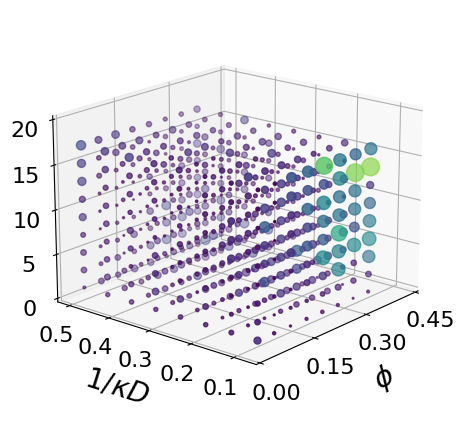

In [11]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(projection='3d')
# ax.view_init(elev=30, azim=64)
ax.view_init(elev=18, azim=-140)
ax.scatter(parameters_grid[:,0],parameters_grid[:,1],np.exp(parameters_grid[:,2]), 
           s=err_grid*2e4, c=err_grid, vmin=0, vmax=0.01,
           marker='o')

ax.set_xlabel(r'$\phi$',fontsize=20)
ax.set_ylabel(r'$1/\kappa D$',fontsize=20)
ax.set_zlabel(r'$AD$',fontsize=20)
ax.set_xticks([0.0,0.15,0.3,0.45])
ax.set_yticks([0.1,0.2,0.3,0.4,0.5])
ax.set_zticks([0,5,10,15,20])
ax.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout(pad=3.5)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.zaxis.labelpad = 10
plt.show()

In [12]:
index_max = np.argmax(err_grid)
params_max = parameters_grid[index_max]
params_max

array([0.345    , 0.08     , 2.7080502])

In [13]:
index_rand = (x_train[:,0]<=0.345)*(np.exp(x_train[:,2])<=20)
sq_GT_rand = y_train[index_rand,:]
sq_KAN_rand = []

Q_test = np.linspace(1.2,20,95)
for x in tqdm(x_train[index_rand,:]):
    # x[2] = np.log(x[2])
    x = x.reshape(1,3)
    sq_KAN = f_SQ_KAN(model_KAN, to_torch_device(x, device=device), Q_test).detach().cpu().numpy().reshape(95)
    sq_KAN_rand.append(sq_KAN)
sq_KAN_rand = np.array(sq_KAN_rand)    



100%|██████████| 5105/5105 [02:35<00:00, 32.89it/s]


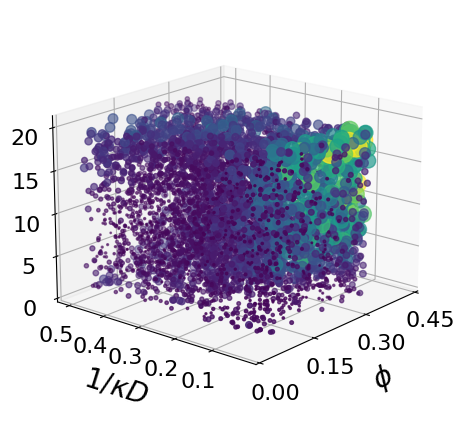

In [14]:
err_rand = np.array([err_L2((sq_GT_rand[i]),(sq_KAN_rand[i])) for i in range(x_train[index_rand,:].shape[0])])
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(projection='3d')
# ax.view_init(elev=30, azim=64)
ax.view_init(elev=18, azim=-140)
ax.scatter(x_train[index_rand,0],x_train[index_rand,1],np.exp(x_train[index_rand,2]), 
           s=err_rand*2e4, c=err_rand, vmin=0, vmax=0.01,
           marker='o')

ax.set_xlabel(r'$\phi$',fontsize=20)
ax.set_ylabel(r'$1/\kappa D$',fontsize=20)
ax.set_zlabel(r'$AD$',fontsize=20)
ax.set_xticks([0.0,0.15,0.3,0.45])
ax.set_yticks([0.1,0.2,0.3,0.4,0.5])
ax.set_zticks([0,5,10,15,20])
ax.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout(pad=3.5)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.zaxis.labelpad = 10
plt.show()

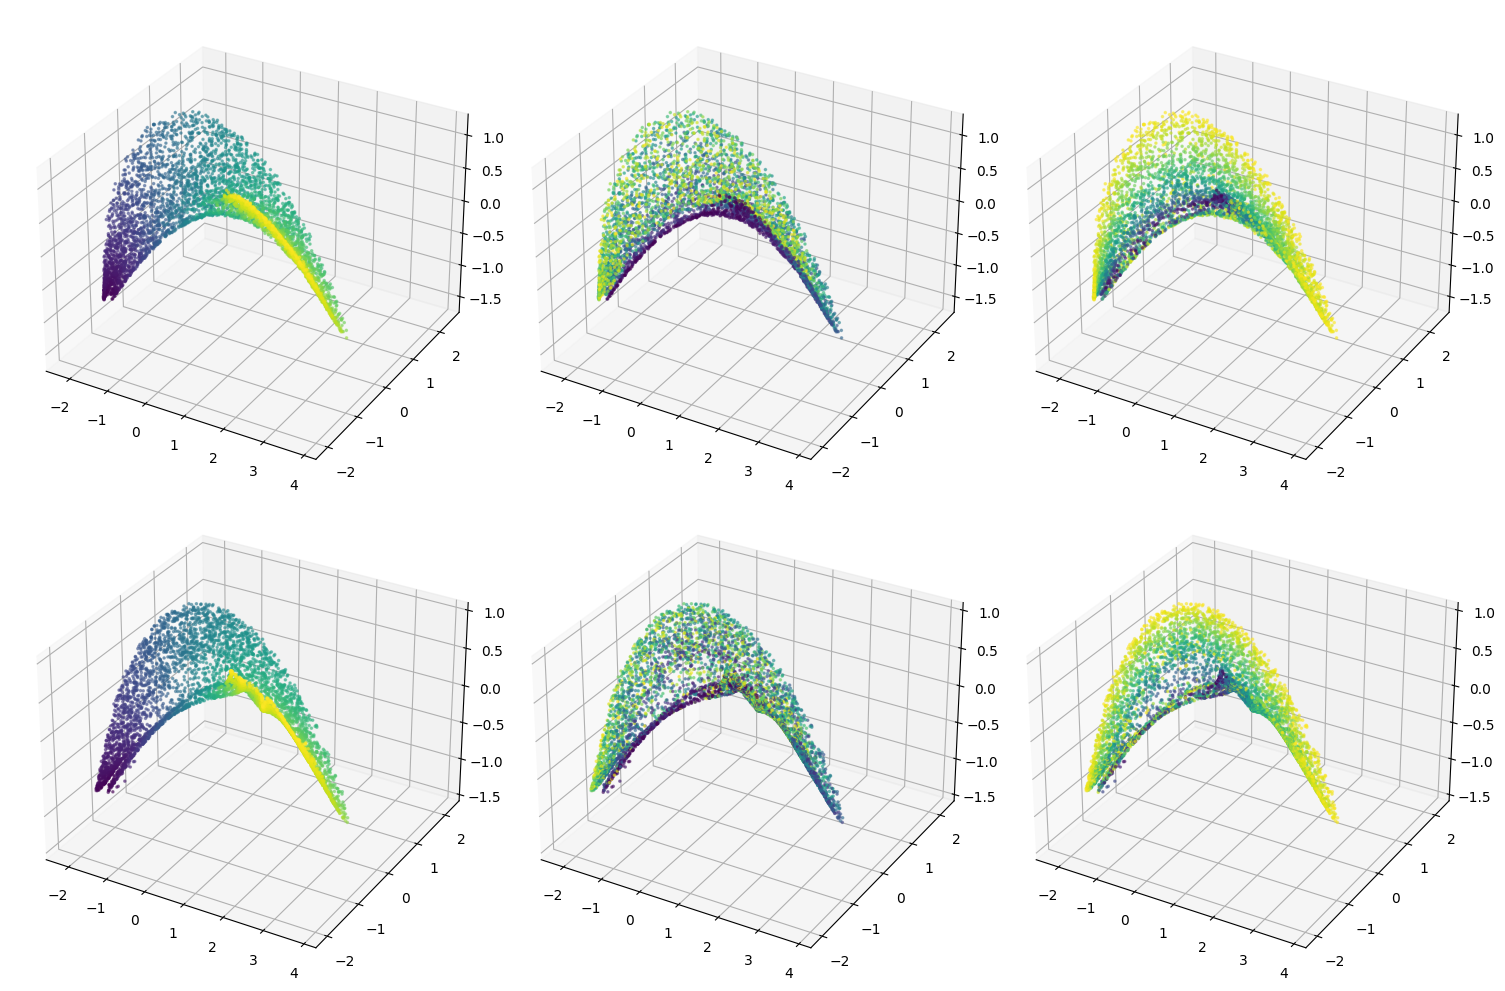

In [15]:
# Assuming sq_KAN_grid and sq_GT_grid are defined
y_KAN = sq_KAN_rand
y_GT = sq_GT_rand

# Perform SVD on y_GT
y_GT_ave = np.mean(y_GT, axis=0)
y_GT_centered = y_GT - y_GT_ave
U_GT, S_GT, Vt_GT = np.linalg.svd(y_GT_centered, full_matrices=False)

# Get the first 3 principal components for y_GT
V_GT = Vt_GT.T

# Project y_KAN onto the basis defined by y_GT
y_KAN_centered = y_KAN - y_GT_ave  # Center y_KAN using the mean of y_GT
PC_KAN_on_GT_basis = np.dot(y_KAN_centered, V_GT[:, :3])

# Project y_GT onto its own basis for comparison
PC_GT = np.dot(y_GT_centered, V_GT[:, :3])

# Create a 3D plot
fig = plt.figure(figsize=(15, 10))
colormap = plt.cm.get_cmap('viridis')  # or any other colormap you like

for i in range(3):
    # Create a colormap based on x_train
    colors_KAN = colormap((x_train[index_rand,i]-np.min(x_train[index_rand,i]))/(np.max(x_train[index_rand,i])-np.min(x_train[index_rand,i])))
    colors_GT = colormap((x_train[index_rand,i]-np.min(x_train[index_rand,i]))/(np.max(x_train[index_rand,i])-np.min(x_train[index_rand,i])))

    ax = fig.add_subplot(2, 3, i+1, projection='3d')

    ax.scatter(PC_GT[:, 0], PC_GT[:, 1], PC_GT[:, 2], c=colors_GT, s=10, alpha=0.5, label='GT', marker='.')
    # ax.legend(frameon=false)
    
for i in range(3):
    # Create a colormap based on x_train
    colors_KAN = colormap((x_train[index_rand,i]-np.min(x_train[index_rand,i]))/(np.max(x_train[index_rand,i])-np.min(x_train[index_rand,i])))
    colors_GT = colormap((x_train[index_rand,i]-np.min(x_train[index_rand,i]))/(np.max(x_train[index_rand,i])-np.min(x_train[index_rand,i])))

    ax = fig.add_subplot(2, 3, i+4, projection='3d')
    ax.scatter(PC_KAN_on_GT_basis[:, 0], PC_KAN_on_GT_basis[:, 1], PC_KAN_on_GT_basis[:, 2], c=colors_KAN, s=10, alpha=0.5, label='KAN', marker='.')
    # ax.legend(frameon=false)

plt.tight_layout()
plt.show()

In [16]:
sq_KAN_grid.shape

(576, 95)

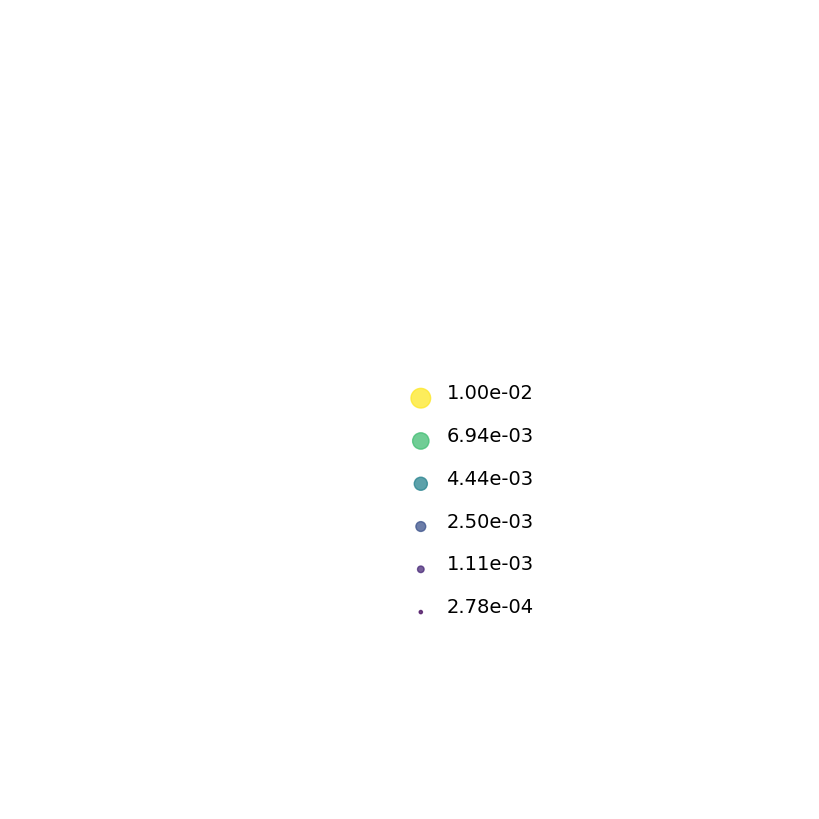

In [17]:
size = ((np.arange(6)+1)/6)**2*0.01

x = np.zeros(6)
y = np.arange(6)/2
z = np.zeros(6)

fig = plt.figure(figsize=(2,3))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=90, azim=-90)
ax.set_box_aspect([1,6,1])
ax.scatter(x, y, z, 
           s=size*2e4, c=size, vmin=0, vmax=0.01, 
           marker='o',alpha=0.75)
for i,s in enumerate(size):
    ax.text(x[i]+0.4, y[i], z[i], 
           '{:0.2e}'.format(s),fontsize=14)

# ax.set_xlabel(r'$\eta$',fontsize=18)
# ax.set_ylabel(r'$1/\kappa D$',fontsize=18)
# ax.set_zlabel(r'$AD$',fontsize=18)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_ylim([-2,7])
ax.set_xlim([-1,1])
ax.set_zlim([-1,1])
ax.axis('off')
plt.tight_layout(pad=0)
plt.gca().set_position([-1.75, -1.2, 4, 4])
plt.show()

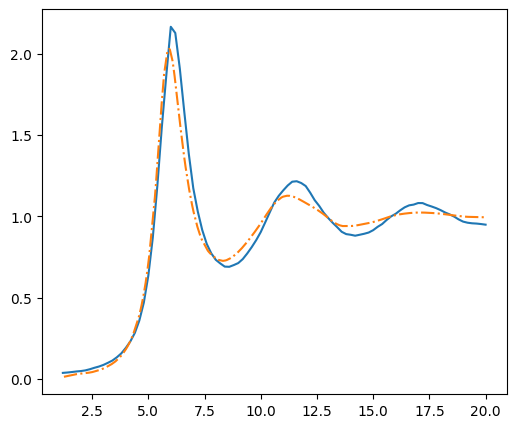

In [18]:
params = np.array([0.315,0.04,17])
index = id_params(params)
x_index = parameters_list[index]
x_index[:,2] = np.log(x_index[:,2])
Q_random = np.sort(np.random.rand(250)*(20-1.2)+1.2)

sq_GT = SQ_list[index,:].T
sq_KAN = f_SQ_KAN(model_KAN, to_torch_device(x_index, device=device), Q_random).detach().cpu().numpy()
    

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot()
ax.plot(Q_train,sq_GT)
ax.plot(Q_random, sq_KAN[0,:],"-.")
# ax.plot(sq_KAN_grid[index])
# err_L2(sq_GT_grid[i],sq_KAN_grid[i])

In [19]:
def G_hs_np(phi, Q):
    """
    Compute G_hs given phi and Q using NumPy.

    Parameters:
    phi (float): A scalar representing the phi value.
    Q (np.ndarray): A 1D array of shape (n_Q,) representing the Q values.

    Returns:
    np.ndarray: A 1D array of shape (n_Q,) representing the computed G_hs values.
    """
    # Compute alpha, beta, and gama
    one_minus_phi = 1 - phi
    one_minus_phi_pow4 = one_minus_phi**4
    one_plus_2phi = 1 + 2 * phi
    one_plus_phi_div2 = 1 + phi / 2

    alpha = (one_plus_2phi**2) / one_minus_phi_pow4
    beta = -6 * phi * (one_plus_phi_div2**2) / one_minus_phi_pow4
    gama = phi * alpha / 2

    # Compute G_hs(Q, phi)
    sin_Q = np.sin(Q)
    cos_Q = np.cos(Q)
    Q_pow2 = Q**2
    Q_pow3 = Q**3
    Q_pow4 = Q**4
    Q_pow5 = Q**5

    term1 = alpha * (sin_Q - Q * cos_Q) / Q_pow2
    term2 = beta * (2 * Q * sin_Q + (2 - Q_pow2) * cos_Q - 2) / Q_pow3
    term3 = gama * (-Q_pow4 * cos_Q + 4 * ((3 * Q_pow2 - 6) * cos_Q + (Q_pow3 - 6 * Q) * sin_Q + 6)) / Q_pow5

    G_hs = term1 + term2 + term3

    return G_hs

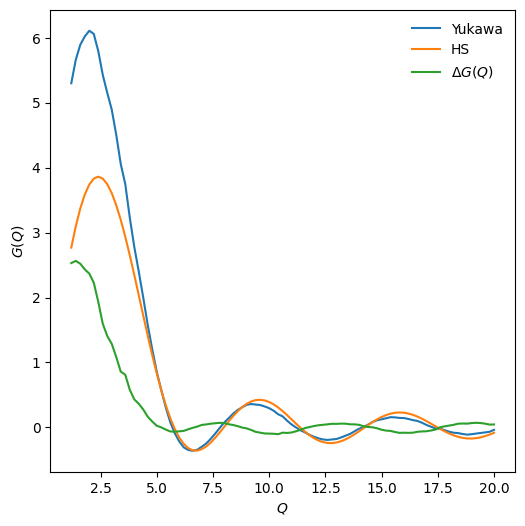

In [20]:
params = np.array([0.405,0.3,3])
index = id_params(params)
x_index = parameters_list[index]
Q_random = np.sort(np.random.rand(250)*20)

sq_GT = SQ_list[index,:].T
sq_KAN = f_SQ_KAN(model_KAN, to_torch_device(x_index, device=device), Q_random).detach().cpu().numpy()
    

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
# ax.plot(Q,sq_GT)
# ax.plot(Q_random, sq_KAN[0,:],"-.")

G_gt = ((1/sq_GT-1)/24/params[0])[:,0]*Q_train
G_hs = G_hs_np(params[0], Q_train)

ax.plot(Q_train,G_gt, label='Yukawa')
ax.plot(Q_train,G_hs, label='HS')
ax.plot(Q_train,(G_gt-G_hs), label=r'$\Delta G(Q)$')
# ax.set_ylim([-3,10])

ax.set_xlabel(r'$Q$')
ax.set_ylabel(r'$G(Q)$')
ax.legend(frameon=False)    

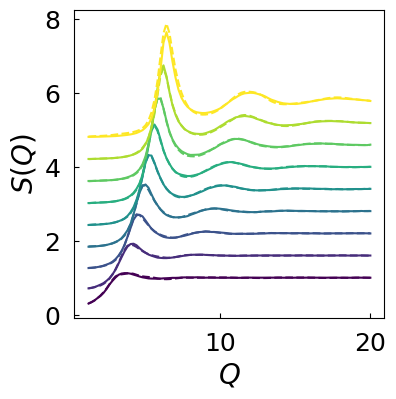

In [21]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()


for i in range(9):
    params = [np.unique(parameters_list[:,0])[i*3+2],0.3,10]
    index = id_params(params)
    color = plt.cm.viridis(i / 8)
    x_index = parameters_list[index]
    x_index[:,2] = np.log(x_index[:,2])
    sq_GT = SQ_list[index,:].T
    sq_KAN = f_SQ_KAN(model_KAN, to_torch_device(x_index, device=device), Q_train).detach().cpu().numpy()
    
    ax.plot(Q_train,sq_GT+0.6*i, color=color)
    ax.plot(Q_train, sq_KAN[0,:]+0.6*i,"--", color=color)
    
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$S(Q)$', fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

In [22]:
x = [1,2,3]
A = x[0]
x[0] = np.log(x[0])
A

1